1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [67]:
import pandas as pd
%matplotlib inline

df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col = 0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [68]:
df = df.replace(['Yes'], 1).replace(['No'], 0) 
df.head()

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

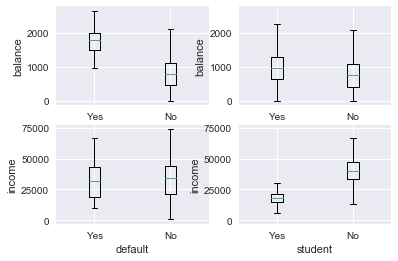

In [69]:
import seaborn
from matplotlib import pylab as plt

f, ((plot1, plot2), (plot3, plot4)) = plt.subplots(2, 2)
plot1.boxplot([df.balance[df.default == 1], df.balance[df.default == 0]])
plot1.set_xticklabels(('Yes', 'No'))
plot1.set_xlabel('default')
plot1.set_ylabel('balance')

plot2.boxplot([df.balance[df.student == 1], df.balance[df.student == 0]])
plot2.set_xticklabels(('Yes', 'No'))
plot2.set_xlabel('student')
plot2.set_ylabel('balance')

plot3.boxplot([df.income[df.default == 1], df.income[df.default == 0]])
plot3.set_xticklabels(('Yes', 'No'))
plot3.set_xlabel('default')
plot3.set_ylabel('income')

plot4.boxplot([df.income[df.student == 1], df.income[df.student == 0]])
plot4.set_xticklabels(('Yes', 'No'))
plot4.set_xlabel('student')
plot4.set_ylabel('income')

plt.show()


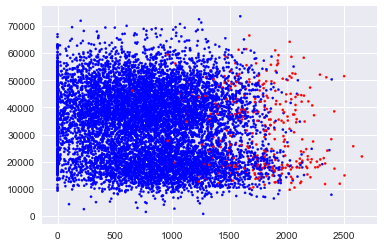

In [70]:
plt.scatter(df.balance, df.income,
            c = df.copy(deep = True).default.replace([1], 'red').replace([0], 'blue'), 
            marker = 'o',
            s = 5)
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

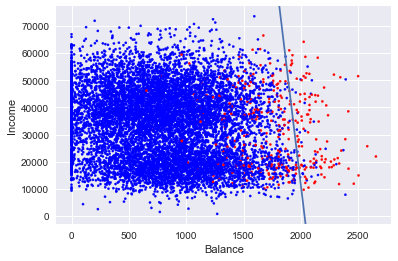

Area under the ROC curve :  0.960949135067


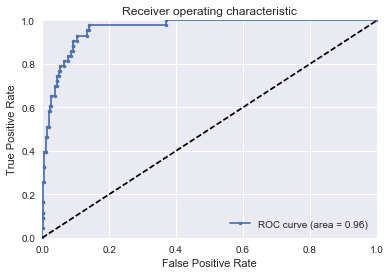

In [71]:
# code referece (http://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html)

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc


y = df.default
X = df.drop(['default', 'student'], 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

# JUST FOR PLOTTING: Though standardization is necessary, it screws up the scale of the scatter plot.
# so the decision boundary may not be the most optimal, but it should be close enough. 
# I did add standardization for AUC ROC (inside generate_auc function from a class python notebook).

logreg = LogisticRegression(penalty='l1')
logreg.fit(X_train, y_train)

plt.scatter(df.balance, df.income,
            c = df.copy(deep = True).default.replace([1], 'red').replace([0], 'blue'), 
            marker = 'o',
            s = 5)

b = logreg.intercept_
w = logreg.coef_[0]

axes = plt.gca()
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()

x = np.arange(xmin, xmax, 1)
y = (b + w[0] * x) / -w[1]

plt.plot(x, y)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('Balance')
plt.ylabel('Income')


plt.show()

# for plotting, standardization 

y = df.default
X = df.drop(['default', 'student'], 1)

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # ADDED STANDARDIZATION
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : ", roc_auc)
    return fpr, tpr, roc_auc, thresholds

def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
generate_ROCplot(fpr,tpr,'LR',roc_auc)


5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

best param:  {'C': 0.70548023107186597, 'penalty': 'l1'}
coeff values:  [-0.21059214  2.785528    0.09073982]


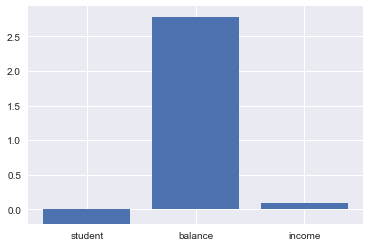

Area under the ROC curve :  0.962194982243


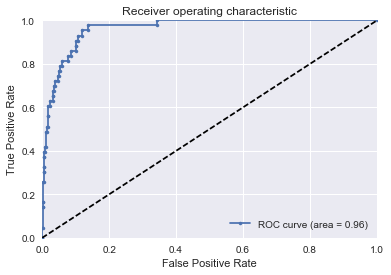

In [72]:
# using l1 instead of l2 

from sklearn.grid_search import GridSearchCV 
from sklearn.preprocessing import StandardScaler

y = df.default
X = df.drop(['default'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

# ADDED STANDARDIZATION
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# using GridSearchCV to find the optimal C for logistic regression with penalty l1 insteand of l2
logreg = LogisticRegression()
params = {'C': np.logspace(-10,5,100), 'penalty' : ['l1']}
clf = GridSearchCV(logreg, params, cv = 5)
clf.fit(X_train, y_train)
print("best param: ", clf.best_params_)

C_optimal = clf.best_params_['C']

logreg = LogisticRegression(C = C_optimal, penalty = 'l1')
logreg.fit(X_train, y_train)

index = np.arange(len(logreg.coef_[0]))

plt.bar(index, logreg.coef_[0])
plt.xticks(index, ("student", "balance", "income"))
print("coeff values: ", logreg.coef_[0])

plt.show()


# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # ADDED STANDARDIZATION
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : ", roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=C_optimal, penalty='l1')

def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)



Adding the student variable makes a little/no difference. (Change of AUC ROC was about 0.002)

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [73]:
# Note: I used GridSearchCV, which requires cross validation to tune C. 
# So I already know that my model generalizes well.

from sklearn.model_selection import cross_val_score

scores = cross_val_score(logreg, X_train, y_train, cv=5)
print(scores)


[ 0.97688944  0.973125    0.973125    0.97125     0.97811132]


Looks good!

Now, I will use the untouched test set to compute the final test result of my model.

In [74]:
logreg.score(X_test, y_test)

0.96999999999999997

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

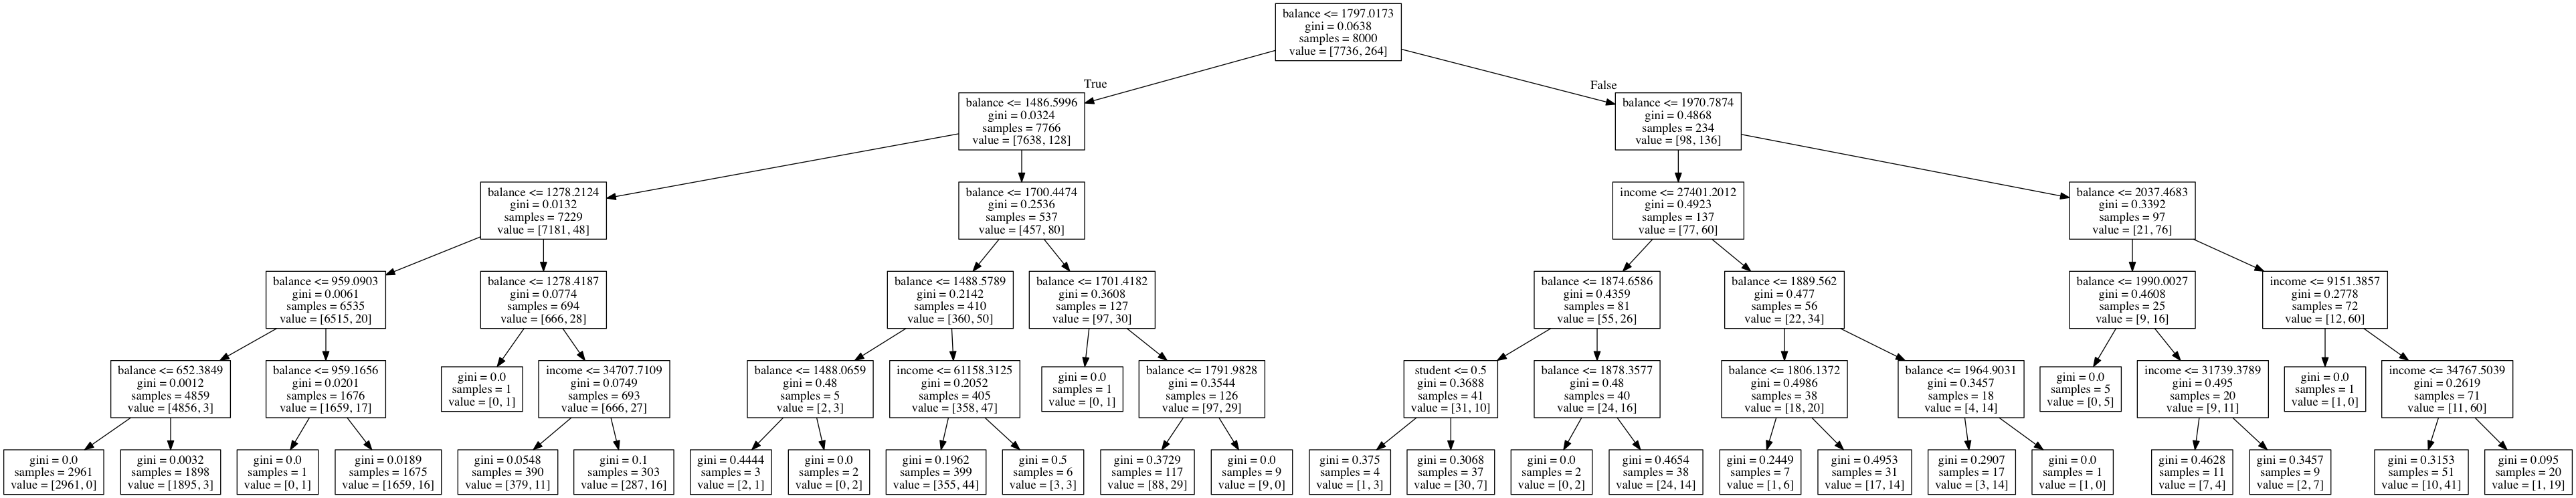

In [113]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus

# features: student, balance, income
y = df.default
X = df.drop(['default'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

dt=DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data, feature_names=X_train.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 



In [114]:
dt.score(X_test, y_test)

0.96899999999999997

Pretty Good. For logistic regression model, the final result score was 0.970 while for decision tree we get 0.969

8) Find the optimal decision tree depth and compute the AUC ROC. 

optimal depth  5


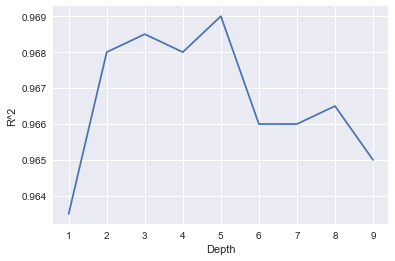

In [127]:
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,10)
for n in depths:
    regr = DecisionTreeClassifier(max_depth=n)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[np.argmax(scores)]
print("optimal depth ", n_opt)

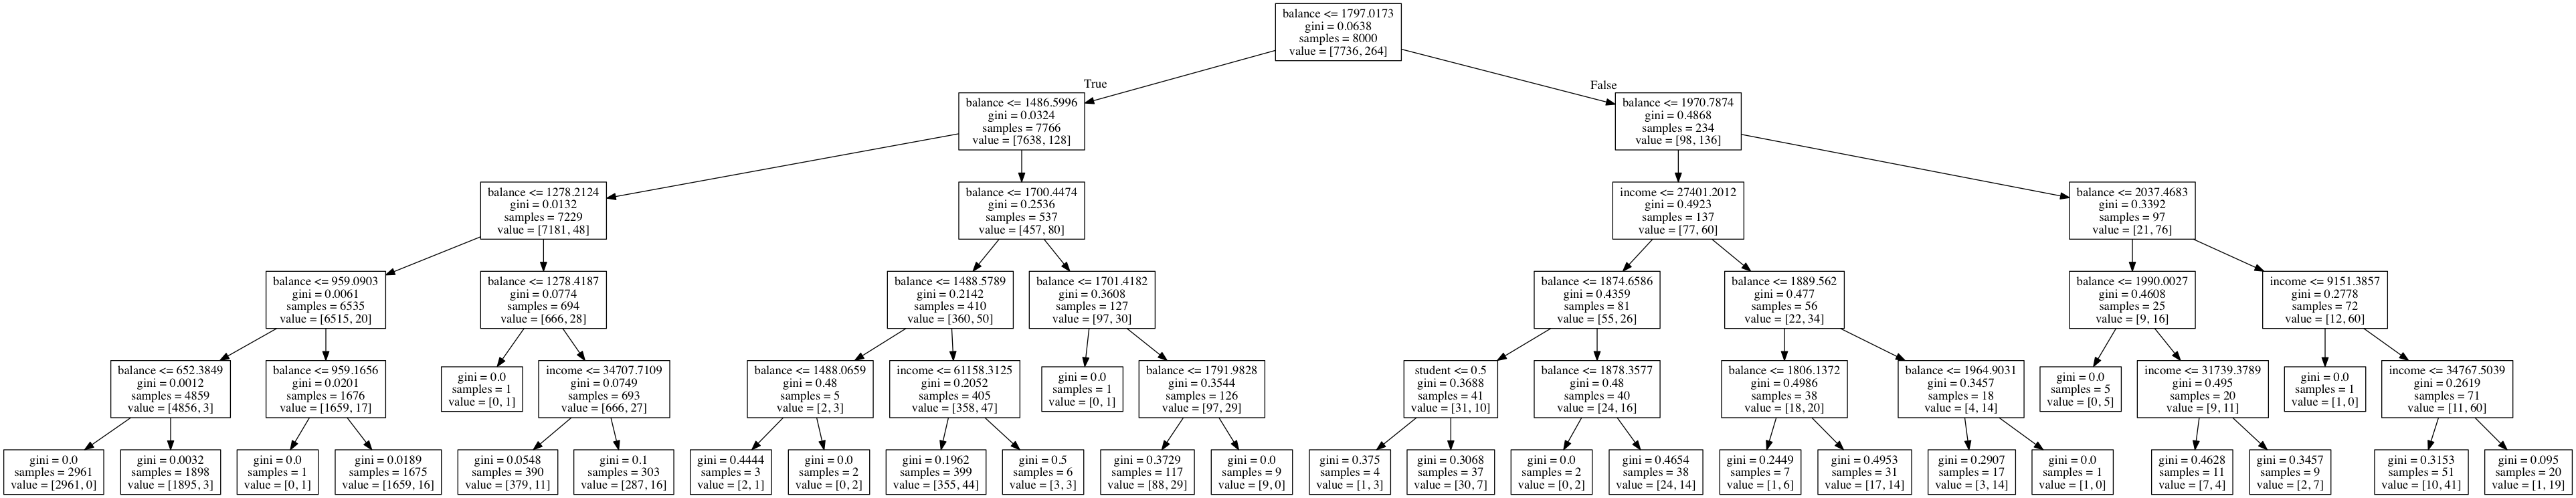

In [128]:
dt=DecisionTreeClassifier(max_depth=n_opt)
dt.fit(X_train, y_train)

dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data, feature_names=X_train.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

In [129]:
dt.score(X_test, y_test)

0.96899999999999997

Area under the ROC curve :  0.954497937908


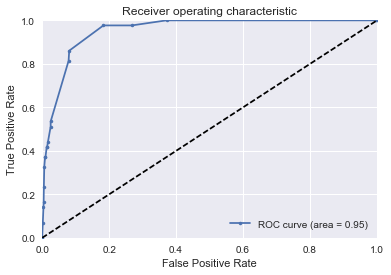

In [130]:
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 5)
generate_ROCplot(fpr,tpr,'LR',roc_auc)